In [ ]:
import time
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus.flowables import Flowable

def generate_report(shapefile2_path, logo_path):
    start_time = time.time()  # Record the start time

    # Read shapefile1 and shapefile2, perform intersection
    shapefile1_path = 'C:/Users/ksahu/Desktop/Kirti_Official/Postal_Polygons_5_24_23 - Original/Postal_Polygons_5_24_23.shp'
    shapefile1 = gpd.read_file(shapefile1_path)

    shapefile2 = gpd.read_file(shapefile2_path)
    shapefile2 = shapefile2.to_crs(shapefile1.crs)

    intersection = gpd.overlay(shapefile1, shapefile2, how='intersection')
    intersection['area in sqkm'] = intersection.area / 10**6
    total_area_intersection = intersection['area in sqkm'].sum()

    # Calculate the ratio of each row's area to the total area
    intersection['area_ratio'] = intersection['area in sqkm'] / total_area_intersection
    intersection['Area Percent'] = intersection['area_ratio'] * 100

    # Plot the first 2 rows of the area column
    ax = intersection.plot(column='Area Percent', cmap='viridis', legend=True)
    for x, y, label in zip(intersection.geometry.centroid.x, intersection.geometry.centroid.y, intersection['FSA_LDU']):
        ax.text(x, y, label, fontsize=8, ha='center', va='center')
    plt.savefig('intersection_plot.png')  # Save the plot as an image
    plt.close()

    # Sort intersection data by 'Area Percent' in descending order
    intersection = intersection.sort_values(by='Area Percent', ascending=False)
    intersection.to_csv('intersection.csv', index=False)

    # Draw a bar graph with 'FSA_LDU' as the x-axis and 'area_ratio' as the y-axis
    plt.figure(figsize=(12, 6))
    plt.bar(intersection['FSA_LDU'], intersection['Area Percent'])
    plt.xlabel('FSA_LDU')
    plt.ylabel('Area Percent')
    plt.title('Area Percent by FSA_LDU')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout for better appearance
    plt.savefig('bar_chart.png')  # Save the bar chart as an image
    plt.close()

    # Read prizm data and perform data manipulation
    prizm_data = pd.read_csv('C:/Users/ksahu/Desktop/Kirti_Official/PRIZM_Rural_Enhanced_License_202101_GEO.csv', encoding='ISO-8859-1')
    intersection['FSA_LDU_No_Space'] = intersection['FSA_LDU'].str.replace(' ', '')
    matched_data = prizm_data[prizm_data['FSALDU'].isin(intersection['FSA_LDU_No_Space'])]
    grouped_data = matched_data.groupby(['FSALDU', 'NAME']).size().reset_index(name='Count')
    groupbysumfsaldu = grouped_data.groupby('FSALDU')['Count'].sum()
    groupbysumfsaldu = groupbysumfsaldu.to_frame()
    merged_df = grouped_data.merge(groupbysumfsaldu, on='FSALDU', how='right')
    merged_df['percent'] = merged_df['Count_x'] / merged_df['Count_y'] * 100
    merged_df['percent'] = round(merged_df['percent'], 1)
    merged_df.to_csv('merged_df.csv', index=False)
    pivot_df = merged_df.pivot(index='FSALDU', columns='NAME', values='percent')
    pivot_df.to_csv('pivot_df.csv', index=True)

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))
    pivot_df.plot(kind='bar', stacked=True)
    plt.xlabel('FSALDU')
    plt.ylabel('Percentage')
    plt.title('Stacked Bar Chart with type and share of the prizm segment by postal code')
    plt.legend(title='NAME', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('stacked_bar_chart.png')  # Save the stacked bar chart as an image
    plt.close()

    # Create the PDF report
    doc = SimpleDocTemplate("report.pdf", pagesize=letter)

    # Create a list of elements to add to the report
    elements = []

    # Add the logo image to the first page
    logo_img = Image(r'C:\Users\ksahu\CRC logo.png', width=100, height=100)
    elements.append(logo_img)

    # Add a title to the first page
    title_style = ParagraphStyle(name='TitleStyle', fontSize=24, textColor='black', spaceAfter=20)
    title = Paragraph(" CRC quick report", style=title_style)
    elements.append(title)
    
     # Add an introductory paragraph to the first page
    intro_paragraph_style = ParagraphStyle(name='IntroParagraphStyle', fontSize=12, textColor='black', spaceAfter=20)
    intro_paragraph = Paragraph("This is an automated report from CRC containing visualizations and analysis of the postal code level data for Novascotia Wildfire 2023.", style=intro_paragraph_style)
    elements.append(intro_paragraph)
    
    # Add the intersection plot image to the report with a description
    intersection_img_description_style = ParagraphStyle(name='ImageDescriptionStyle', fontSize=10, textColor='black', spaceAfter=10)
    intersection_img_description = Paragraph("Intersection Plot - This plot shows the intersection between postal code level shape file and Nova Scotia evacuation wildfire evaciuation areas with the percentage of the area distribution Km2.", style=intersection_img_description_style)
    elements.append(intersection_img_description)
    intersection_plot_img = Image("intersection_plot.png", width=500, height=300)
    elements.append(intersection_plot_img)

    # Add the bar chart image to the report with a description
    bar_chart_img_description_style = ParagraphStyle(name='ImageDescriptionStyle', fontSize=10, textColor='black', spaceAfter=10)
    bar_chart_img_description = Paragraph("Bar Chart - This bar chart shows the percentage area distribution by FSA_LDU.", style=bar_chart_img_description_style)
    elements.append(bar_chart_img_description)
    bar_chart_img = Image("bar_chart.png", width=500, height=300)
    elements.append(bar_chart_img)

    # Add the stacked bar chart image to the report with a description
    stacked_bar_chart_img_description_style = ParagraphStyle(name='ImageDescriptionStyle', fontSize=10, textColor='black', spaceAfter=10)
    stacked_bar_chart_img_description = Paragraph("Stacked Bar Chart - This stacked bar chart shows the percentage distribution of the prizm segment by postal code.", style=stacked_bar_chart_img_description_style)
    elements.append(stacked_bar_chart_img_description)
    stacked_bar_chart_img = Image("stacked_bar_chart.png", width=500, height=300)
    elements.append(stacked_bar_chart_img)
    
    # Calculate the time taken
    end_time = time.time()
    time_taken = end_time - start_time

    # Add the time taken to the report
    time_taken_style = ParagraphStyle(name='TimeTakenStyle', fontSize=10, textColor='black', spaceBefore=20)
    time_taken_paragraph = Paragraph(f"Time taken to generate the report: {time_taken:.2f} seconds.", style=time_taken_style)
    elements.append(time_taken_paragraph)
    page_number_style = ParagraphStyle(name='PageNumberStyle', fontSize=10, textColor='black', spaceBefore=20)
    header_style = ParagraphStyle(name='HeaderStyle', fontSize=12, textColor='black', spaceAfter=10)
    footer_style = ParagraphStyle(name='FooterStyle', fontSize=8, textColor='black', spaceBefore=10, alignment=1)

    header = Paragraph("Automated Report - Header", style=header_style)
    footer = Paragraph(f"Page <pageNumber> - Time taken to generate the report: {time_taken:.2f} seconds.", style=footer_style)
    page_number = Paragraph("<pageNumber>", style=page_number_style)


    # Build the PDF document with the list of elements
    doc.build(elements)

# Call the function with the shapefile2 path and logo path
generate_report('C:/Users/ksahu/Desktop/Kirti_Official/OneDrive_1_7-19-2023/Shelburne County Evacuation Area.shp', 'logo.png')


In [5]:
import geopandas as gpd
import time
  # Record the start time
shapefile2 = gpd.read_file('C:/Users/ksahu/Desktop/Kirti_Official/OneDrive_1_7-19-2023/Shelburne County Evacuation Area.shp')
#shapefile2 = shapefile2.to_crs(shapefile1.crs)

#intersection = gpd.overlay(shapefile1, shapefile2, how='intersection')


<Axes: >

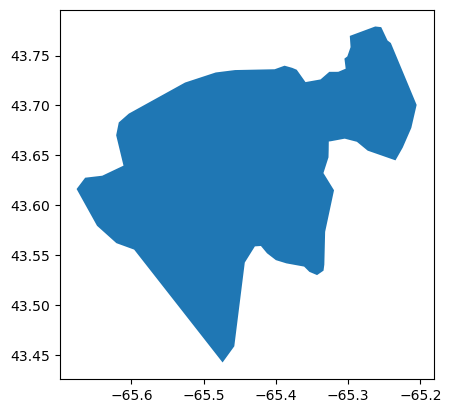

In [2]:
shapefile2.plot()

In [4]:
start_time = time.time()
shapefile1 = gpd.read_file('C:/Users/ksahu/Desktop/Kirti_Official/crs conversion/lda_wgs84.shp')
end_time = time.time()
time_taken = end_time - start_time
time_taken

42.87267518043518

C:\Users\ksahu\Anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

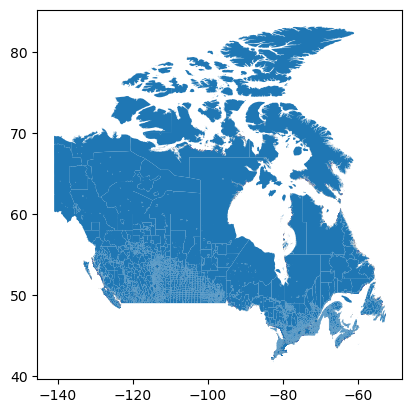

In [4]:
shapefile1.plot()